In [2]:
import rasterio
import rasterio.plot
from rasterio.plot import show_hist
import pandas as pd
import geopandas as gpd
import numpy as np
from rasterio.sample import sample_gen

In [3]:
src = rasterio.open(r"/Users/user/Desktop/AIPISCIAA/NGA_population_v2_1_gridded/NGA_population_v2_1_gridded.tif")

In [4]:
src.closed

False

In [5]:
array = src.read(1)
array.shape

(11546, 14413)

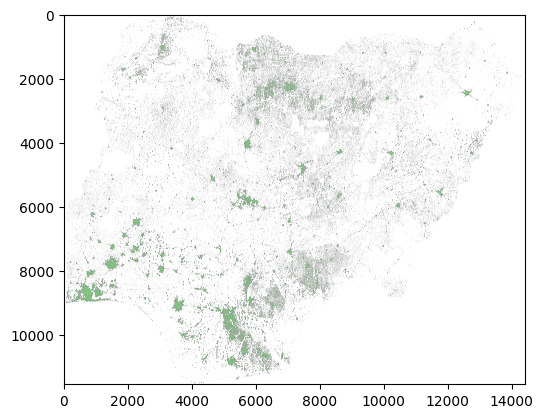

In [6]:
# Gridded dataset
import matplotlib.pyplot as plt

plt.imshow(array, cmap="Accent")
plt.show()

In [7]:
# Converting array to dataframe if possible:
array.shape

(11546, 14413)

In [8]:
# More analysis
print(f"Spatial Bounding Box: {src.bounds}")
print(f"Number of Bands: {src.count}")
print(f"Number of Columns of Raster Dataset: {src.width}")
print(f"Number of Columns of Rows Dataset: {src.height}")
print(f"Coordinate Reference System: {src.crs}")

Spatial Bounding Box: BoundingBox(left=2.668750004, bottom=4.270416851052314, right=14.679583289, top=13.892083479)
Number of Bands: 1
Number of Columns of Raster Dataset: 14413
Number of Columns of Rows Dataset: 11546
Coordinate Reference System: EPSG:4326


In [9]:
src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 14413,
 'height': 11546,
 'count': 1,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(0.0008333333299798793, 0.0, 2.668750004,
        0.0, -0.0008333333299798793, 13.892083479)}

### Scenario 1: Merge all dataset

In [23]:
import pandas as pd

# 1. Load the shapefile (schools)
schools = gpd.read_file("/Users/user/Desktop/AIPISCIAA/data/GRID3/GRID3_NGA_-_Schools.shp")

# 2. Load the raster
raster = rasterio.open("/Users/user/Desktop/AIPISCIAA/NGA_population_v2_1_gridded/NGA_population_v2_1_gridded.tif")

# 3. Reproject schools to match raster CRS if needed
if schools.crs != raster.crs:
    schools = schools.to_crs(raster.crs)

# 4. Extract raster values at each school point location
coords = [(x,y) for x, y in zip(schools.geometry.x, schools.geometry.y)]
raster_values = [val[0] for val in raster.sample(coords)]

# 5. Add raster values as a new column in the GeoDataFrame
schools["raster_value"] = raster_values

# 6. Convert to DataFrame and save as CSV
df = pd.DataFrame(schools.drop(columns="geometry"))


# Load datasets
edu_df = pd.read_csv(r"/Users/user/Desktop/AIPISCIAA/data/EAP_3EAP_SEX_AGE_EDU_NB_A-filtered-2025-08-13.csv")
stu_df = pd.read_csv(r"/Users/user/Desktop/AIPISCIAA/data/EAP_3EAP_SEX_AGE_STU_NB_A-filtered-2025-08-13.csv")

# Pick the most recent year
latest_year_edu = edu_df["time"].max()
latest_year_stu = stu_df["time"].max()

# Filter only that year
edu_summary = edu_df[edu_df["time"] == latest_year_edu][["classif2.label","obs_value"]]
stu_summary = stu_df[stu_df["time"] == latest_year_stu][["classif2.label","obs_value"]]

# Convert to dicts {category: value}
edu_dict = dict(zip(edu_summary["classif2.label"], edu_summary["obs_value"]))
stu_dict = dict(zip(stu_summary["classif2.label"], stu_summary["obs_value"]))

# Copy facilities_df and broadcast stats to each row
merged_with_stats = df.copy()
for k,v in edu_dict.items():
    merged_with_stats[f"edu_{k}"] = v
for k,v in stu_dict.items():
    merged_with_stats[f"stu_{k}"] = v


In [24]:
# Load dataset schools_with_population_and_national_stats
merged_with_stats.head()

,FID,globalid,uniq_id,timestamp,editor,wardname,wardcode,lganame,lgacode,statename,...,raster_value,edu_Education (Aggregate levels): Total,edu_Education (Aggregate levels): Less than basic,edu_Education (Aggregate levels): Basic,edu_Education (Aggregate levels): Intermediate,edu_Education (Aggregate levels): Advanced,stu_Educational attendance: Total,stu_Educational attendance: Attending,stu_Educational attendance: Not attending,stu_Educational attendance: Not elsewhere classified
0,1,4621765a-c0db-4120-818c-94ce02e797cf,843109,2020-12-11,najib.adam,Yolde Kohi,ADSYLA11,Yola South,2021,Adamawa,...,0.000000,9971.72,626.165,1949.044,6423.254,973.258,9971.72,867.138,8544.652,559.931
1,2,24bb89c3-adf7-4af4-a6fc-81b719d55f58,842344,2020-12-11,najib.adam,Wara / Osin / Egbejila,KWSLRN12,Ilorin West,24008,Kwara,...,15.127633,9971.72,626.165,1949.044,6423.254,973.258,9971.72,867.138,8544.652,559.931
2,3,c737e76f-74a3-43e8-b07e-47f0ce066c35,842345,2020-12-11,najib.adam,Ganjuwa B,BA0812,Ganjuwa,5008,Bauchi,...,13.671908,9971.72,626.165,1949.044,6423.254,973.258,9971.72,867.138,8544.652,559.931
3,4,5f7e1c73-f7ec-48cd-9d34-16a3a10a8dea,842413,2020-12-11,najib.adam,Kotonkoro,NISBMG08,Mariga,27015,Niger,...,4.578063,9971.72,626.165,1949.044,6423.254,973.258,9971.72,867.138,8544.652,559.931
4,5,932b2b1e-fe08-4f40-b58d-ba4c129882ac,842415,2020-12-11,najib.adam,Tegina Central,NISKAG10,Rafi,27020,Niger,...,4.467844,9971.72,626.165,1949.044,6423.254,973.258,9971.72,867.138,8544.652,559.931


In [25]:
merged_with_stats.shape

(107670, 31)

In [26]:
merged_with_stats.columns

Index(['FID', 'globalid', 'uniq_id', 'timestamp', 'editor', 'wardname',
       'wardcode', 'lganame', 'lgacode', 'statename', 'statecode',
       'secondary_', 'student_ct', 'teacher_ct', 'poi_type', 'education',
       'management', 'subtype', 'category', 'name', 'source', 'raster_value',
       'edu_Education (Aggregate levels): Total',
       'edu_Education (Aggregate levels): Less than basic',
       'edu_Education (Aggregate levels): Basic',
       'edu_Education (Aggregate levels): Intermediate',
       'edu_Education (Aggregate levels): Advanced',
       'stu_Educational attendance: Total',
       'stu_Educational attendance: Attending',
       'stu_Educational attendance: Not attending',
       'stu_Educational attendance: Not elsewhere classified'],
      dtype='object')

In [27]:
merged_with_stats.tail()

,FID,globalid,uniq_id,timestamp,editor,wardname,wardcode,lganame,lgacode,statename,...,raster_value,edu_Education (Aggregate levels): Total,edu_Education (Aggregate levels): Less than basic,edu_Education (Aggregate levels): Basic,edu_Education (Aggregate levels): Intermediate,edu_Education (Aggregate levels): Advanced,stu_Educational attendance: Total,stu_Educational attendance: Attending,stu_Educational attendance: Not attending,stu_Educational attendance: Not elsewhere classified
107665,107666,fbc237fb-d0c7-4148-aada-eff62b55d69b,958136,2020-12-11,najib.adam,Umanya 1,ANSHTE14,Oyi,4021,Anambra,...,75.277290,9971.72,626.165,1949.044,6423.254,973.258,9971.72,867.138,8544.652,559.931
107666,107667,ce9b1eb5-8eba-473e-863f-61b0a346cf71,958137,2020-05-13,najib.adam,Amata / Akpoha / Obiozara,EBSBZR03,Ohaozara,11011,Ebonyi,...,48.313499,9971.72,626.165,1949.044,6423.254,973.258,9971.72,867.138,8544.652,559.931
107667,107668,2007649d-cc2b-4913-91b1-ea492a1a8fb0,958138,2020-12-11,najib.adam,College / Egbada Road / Isale Offa,OSSBOE04,Boripe,30006,Osun,...,53.434975,9971.72,626.165,1949.044,6423.254,973.258,9971.72,867.138,8544.652,559.931
107668,107669,b79cba7e-61d2-451a-b2b5-305d117a4c75,958139,2020-12-11,najib.adam,Emevor,DTSDSZ02,Isoko North,10009,Delta,...,54.360744,9971.72,626.165,1949.044,6423.254,973.258,9971.72,867.138,8544.652,559.931
107669,107670,ee143979-c808-4e97-812c-c9fb28cdc8ef,958140,2020-12-11,najib.adam,Omward 7,RVSBER07,Omumma,33019,Rivers,...,37.344398,9971.72,626.165,1949.044,6423.254,973.258,9971.72,867.138,8544.652,559.931


In [28]:
print(merged_with_stats.columns.tolist())
print(merged_with_stats.head())

['FID', 'globalid', 'uniq_id', 'timestamp', 'editor', 'wardname', 'wardcode', 'lganame', 'lgacode', 'statename', 'statecode', 'secondary_', 'student_ct', 'teacher_ct', 'poi_type', 'education', 'management', 'subtype', 'category', 'name', 'source', 'raster_value', 'edu_Education (Aggregate levels): Total', 'edu_Education (Aggregate levels): Less than basic', 'edu_Education (Aggregate levels): Basic', 'edu_Education (Aggregate levels): Intermediate', 'edu_Education (Aggregate levels): Advanced', 'stu_Educational attendance: Total', 'stu_Educational attendance: Attending', 'stu_Educational attendance: Not attending', 'stu_Educational attendance: Not elsewhere classified']
   FID                              globalid  uniq_id  timestamp      editor  \
0    1  4621765a-c0db-4120-818c-94ce02e797cf   843109 2020-12-11  najib.adam   
1    2  24bb89c3-adf7-4af4-a6fc-81b719d55f58   842344 2020-12-11  najib.adam   
2    3  c737e76f-74a3-43e8-b07e-47f0ce066c35   842345 2020-12-11  najib.adam   
3 

In [29]:
merged_with_stats.shape

(107670, 31)

In [30]:
import pandas as pd

def load_wpp_excel(path):
    wpp = pd.read_excel(path, skiprows=16)

    # Keep only Nigeria
    wpp = wpp[wpp["Region, subregion, country or area *"] == "Nigeria"]

    # ID vars we want to keep
    id_vars = ["Year", "Region, subregion, country or area *"]

    # Age group columns = all numeric or ending with "+"
    age_group_cols = [c for c in wpp.columns if c not in id_vars and not c.startswith(("Index", "Variant", "Notes", "Location", "ISO", "SDMX", "Type", "Parent"))]

    # Reshape wide → long
    wpp_long = wpp.melt(
        id_vars=id_vars,
        value_vars=age_group_cols,
        var_name="AgeGroup",
        value_name="WPP_Population"
    )

    # Rename
    wpp_long = wpp_long.rename(columns={
        "Region, subregion, country or area *": "AdminUnit"
    })

    # Drop any NaN population rows just in case
    wpp_long = wpp_long.dropna(subset=["WPP_Population"])

    return wpp_long[["Year", "AgeGroup", "WPP_Population", "AdminUnit"]]

# --- Test it ---
wpp_df = load_wpp_excel("/Users/user/Desktop/AIPISCIAA/data/WPP2024_POP_F02_1_POPULATION_5-YEAR_AGE_GROUPS_BOTH_SEXES.xlsx")
print(wpp_df.head(15))
print(wpp_df["AgeGroup"].unique()[:10])  # check age group labels
print(wpp_df.shape)


      Year AgeGroup WPP_Population AdminUnit
0   1950.0      0-4       6263.044   Nigeria
1   1951.0      0-4      6324.1265   Nigeria
2   1952.0      0-4       6408.003   Nigeria
3   1953.0      0-4      6533.1995   Nigeria
4   1954.0      0-4       6694.664   Nigeria
5   1955.0      0-4       6855.275   Nigeria
6   1956.0      0-4       7008.931   Nigeria
7   1957.0      0-4       7169.676   Nigeria
8   1958.0      0-4       7334.833   Nigeria
9   1959.0      0-4      7502.9135   Nigeria
10  1960.0      0-4      7677.2025   Nigeria
11  1961.0      0-4         7858.7   Nigeria
12  1962.0      0-4       8049.993   Nigeria
13  1963.0      0-4      8250.4385   Nigeria
14  1964.0      0-4       8459.771   Nigeria
['0-4' '5-9' '10-14' '15-19' '20-24' '25-29' '30-34' '35-39' '40-44'
 '45-49']
(1554, 4)


In [31]:
import pandas as pd
import geopandas as gpd
import rasterio

def load_integrated_data(schools_path, raster_path, edu_csv, stu_csv, wpp_excel):
    # 1. Load the shapefile (schools)
    schools = gpd.read_file(schools_path)

    # 2. Load the raster
    raster = rasterio.open(raster_path)

    # 3. Reproject schools to match raster CRS if needed
    if schools.crs != raster.crs:
        schools = schools.to_crs(raster.crs)

    # 4. Extract raster values at each school point location
    coords = [(x, y) for x, y in zip(schools.geometry.x, schools.geometry.y)]
    raster_values = [val[0] for val in raster.sample(coords)]

    # 5. Add raster values as a new column in the GeoDataFrame
    schools["raster_value"] = raster_values

    # 6. Convert to DataFrame
    df = pd.DataFrame(schools.drop(columns="geometry"))

    # 7. Load UNESCO datasets
    edu_df = pd.read_csv(edu_csv)
    stu_df = pd.read_csv(stu_csv)

    # Keep all years (not just latest)
    edu_summary = edu_df[["time", "classif2.label", "obs_value"]]
    stu_summary = stu_df[["time", "classif2.label", "obs_value"]]

    # Pivot to wide format
    edu_wide = edu_summary.pivot_table(
        index="time", columns="classif2.label", values="obs_value"
    ).reset_index()
    stu_wide = stu_summary.pivot_table(
        index="time", columns="classif2.label", values="obs_value"
    ).reset_index()

    # Rename columns
    edu_wide = edu_wide.rename(columns=lambda c: f"edu_{c}" if c != "time" else "Year")
    stu_wide = stu_wide.rename(columns=lambda c: f"stu_{c}" if c != "time" else "Year")

    # Merge UNESCO edu + stu
    unesco_df = pd.merge(edu_wide, stu_wide, on="Year", how="outer")

    # 8. Load WPP Excel
    wpp = pd.read_excel(wpp_excel, skiprows=16)  # adjust skiprows if needed
    wpp = wpp.rename(columns={"Region, subregion, country or area *": "AdminUnit"})
    wpp = wpp.melt(id_vars=["AdminUnit"], var_name="Year", value_name="WPP_value")

    # Fix Year column (remove non-numeric)
    wpp = wpp[wpp["Year"].astype(str).str.isnumeric()]
    wpp["Year"] = wpp["Year"].astype(int)

    # 9. Merge UNESCO + WPP on Year
    combined = pd.merge(unesco_df, wpp, on="Year", how="left")

    # 10. Broadcast combined stats onto facilities_df
    # merged_with_stats = df.copy()
    # for col in combined.columns:
    #     if col not in ["Year", "AdminUnit"]:
    #         merged_with_stats[col] = combined[col].values[0] if not combined.empty else None
    # 10. Pivot combined so each Year is in the column name
    merged_with_stats = df.copy()
    for col in combined.columns:
        if col not in ["Year", "AdminUnit"]:
            for y in combined["Year"].unique():
                new_col = f"{col}_{y}"
                merged_with_stats[new_col] = combined.loc[combined["Year"]==y, col].values[0]



    return merged_with_stats


In [32]:
data = load_integrated_data(
    "/Users/user/Desktop/AIPISCIAA/data/GRID3/GRID3_NGA_-_Schools.shp",
    "/Users/user/Desktop/AIPISCIAA/NGA_population_v2_1_gridded/NGA_population_v2_1_gridded.tif",
    "/Users/user/Desktop/AIPISCIAA/data/EAP_3EAP_SEX_AGE_EDU_NB_A-filtered-2025-08-13.csv",
    "/Users/user/Desktop/AIPISCIAA/data/EAP_3EAP_SEX_AGE_STU_NB_A-filtered-2025-08-13.csv",
    "/Users/user/Desktop/AIPISCIAA/data/WPP2024_POP_F02_1_POPULATION_5-YEAR_AGE_GROUPS_BOTH_SEXES.xlsx"
)

print(data.head())
print(data.columns)


   FID                              globalid  uniq_id  timestamp      editor  \
0    1  4621765a-c0db-4120-818c-94ce02e797cf   843109 2020-12-11  najib.adam   
1    2  24bb89c3-adf7-4af4-a6fc-81b719d55f58   842344 2020-12-11  najib.adam   
2    3  c737e76f-74a3-43e8-b07e-47f0ce066c35   842345 2020-12-11  najib.adam   
3    4  5f7e1c73-f7ec-48cd-9d34-16a3a10a8dea   842413 2020-12-11  najib.adam   
4    5  932b2b1e-fe08-4f40-b58d-ba4c129882ac   842415 2020-12-11  najib.adam   

                 wardname  wardcode      lganame lgacode statename  ...  \
0              Yolde Kohi  ADSYLA11   Yola South    2021   Adamawa  ...   
1  Wara / Osin / Egbejila  KWSLRN12  Ilorin West   24008     Kwara  ...   
2               Ganjuwa B    BA0812      Ganjuwa    5008    Bauchi  ...   
3               Kotonkoro  NISBMG08       Mariga   27015     Niger  ...   
4          Tegina Central  NISKAG10         Rafi   27020     Niger  ...   

  stu_Educational attendance: Total_2013  \
0                       

In [33]:
data.head()

,FID,globalid,uniq_id,timestamp,editor,wardname,wardcode,lganame,lgacode,statename,...,stu_Educational attendance: Total_2013,stu_Educational attendance: Total_2016,stu_Educational attendance: Total_2019,stu_Educational attendance: Total_2022,stu_Educational attendance: Total_2023,WPP_value_2013,WPP_value_2016,WPP_value_2019,WPP_value_2022,WPP_value_2023
0,1,4621765a-c0db-4120-818c-94ce02e797cf,843109,2020-12-11,najib.adam,Yolde Kohi,ADSYLA11,Yola South,2021,Adamawa,...,7433.036,8047.1555,9147.4555,15073.655,14574.534,NaN,NaN,NaN,NaN,NaN
1,2,24bb89c3-adf7-4af4-a6fc-81b719d55f58,842344,2020-12-11,najib.adam,Wara / Osin / Egbejila,KWSLRN12,Ilorin West,24008,Kwara,...,7433.036,8047.1555,9147.4555,15073.655,14574.534,NaN,NaN,NaN,NaN,NaN
2,3,c737e76f-74a3-43e8-b07e-47f0ce066c35,842345,2020-12-11,najib.adam,Ganjuwa B,BA0812,Ganjuwa,5008,Bauchi,...,7433.036,8047.1555,9147.4555,15073.655,14574.534,NaN,NaN,NaN,NaN,NaN
3,4,5f7e1c73-f7ec-48cd-9d34-16a3a10a8dea,842413,2020-12-11,najib.adam,Kotonkoro,NISBMG08,Mariga,27015,Niger,...,7433.036,8047.1555,9147.4555,15073.655,14574.534,NaN,NaN,NaN,NaN,NaN
4,5,932b2b1e-fe08-4f40-b58d-ba4c129882ac,842415,2020-12-11,najib.adam,Tegina Central,NISKAG10,Rafi,27020,Niger,...,7433.036,8047.1555,9147.4555,15073.655,14574.534,NaN,NaN,NaN,NaN,NaN


#### Scenario 2

In [46]:
import pandas as pd
import geopandas as gpd
import rasterio

def load_integrated_data(schools_path, raster_path, edu_csv, stu_csv, wpp_excel):
    # 1. Load schools shapefile
    schools = gpd.read_file(schools_path)

    # 2. Load raster
    raster = rasterio.open(raster_path)

    # 3. Reproject schools if needed
    if schools.crs != raster.crs:
        schools = schools.to_crs(raster.crs)

    # 4. Extract raster values at each school point
    coords = [(x, y) for x, y in zip(schools.geometry.x, schools.geometry.y)]
    raster_values = [val[0] for val in raster.sample(coords)]
    schools["raster_value"] = raster_values

    # 5. Convert schools to DataFrame
    schools_df = pd.DataFrame(schools.drop(columns="geometry"))

    # 6. Load UNESCO edu/stu datasets
    edu_df = pd.read_csv(edu_csv)[["time", "classif2.label", "obs_value"]]
    stu_df = pd.read_csv(stu_csv)[["time", "classif2.label", "obs_value"]]

    # 7. Pivot edu/stu to wide format per year
    edu_wide = edu_df.pivot_table(index="time", columns="classif2.label", values="obs_value").reset_index()
    stu_wide = stu_df.pivot_table(index="time", columns="classif2.label", values="obs_value").reset_index()

    edu_wide = edu_wide.rename(columns=lambda c: f"edu_{c}" if c != "time" else "Year")
    stu_wide = stu_wide.rename(columns=lambda c: f"stu_{c}" if c != "time" else "Year")

    # Merge edu + stu
    unesco_df = pd.merge(edu_wide, stu_wide, on="Year", how="outer")

    # 8. Load WPP Excel and reshape
    wpp = pd.read_excel(wpp_excel, skiprows=16)
    wpp = wpp[wpp["Region, subregion, country or area *"] == "Nigeria"]
    id_vars = ["Year", "Region, subregion, country or area *"]
    # age_cols = [c for c in wpp.columns if c not in id_vars and not c.startswith(("Index", "Variant", "Notes"))]
    # Keep only numeric or "X+" columns as age groups
    # age_cols = [c for c in latest_row.columns if str(c).replace("+","").replace("-","").isdigit() == False and ( "-" in str(c) or "+" in str(c))]

    # Keep only age group columns: either "X-Y" or "X+"
    age_cols = [
    c for c in wpp.columns
    if c not in id_vars + ["ISO3 Alpha-code", "ISO2 Alpha-code"] and ('-' in c or c.endswith('+'))
    ]



    wpp_long = wpp.melt(id_vars=id_vars, value_vars=age_cols, var_name="AgeGroup", value_name="WPP_value")
    wpp_long = wpp_long.rename(columns={"Region, subregion, country or area *": "AdminUnit"})

    # Drop NaNs
    wpp_long = wpp_long.dropna(subset=["WPP_value"])

    # 9. Merge UNESCO + WPP on Year
    combined = pd.merge(unesco_df, wpp_long, on="Year", how="left")

    # 10. Broadcast combined to schools (one row per school per year)
    schools_df["key"] = 1
    combined["key"] = 1
    merged = pd.merge(schools_df, combined, on="key").drop(columns="key")

    # Now each school has a row per Year, with edu, stu, and WPP values
    return merged


In [47]:
data_2 = load_integrated_data(
    "/Users/user/Desktop/AIPISCIAA/data/GRID3/GRID3_NGA_-_Schools.shp",
    "/Users/user/Desktop/AIPISCIAA/NGA_population_v2_1_gridded/NGA_population_v2_1_gridded.tif",
    "/Users/user/Desktop/AIPISCIAA/data/EAP_3EAP_SEX_AGE_EDU_NB_A-filtered-2025-08-13.csv",
    "/Users/user/Desktop/AIPISCIAA/data/EAP_3EAP_SEX_AGE_STU_NB_A-filtered-2025-08-13.csv",
    "/Users/user/Desktop/AIPISCIAA/data/WPP2024_POP_F02_1_POPULATION_5-YEAR_AGE_GROUPS_BOTH_SEXES.xlsx"
)

print(data_2.columns)

Index(['FID', 'globalid', 'uniq_id', 'timestamp', 'editor', 'wardname',
       'wardcode', 'lganame', 'lgacode', 'statename', 'statecode',
       'secondary_', 'student_ct', 'teacher_ct', 'poi_type', 'education',
       'management', 'subtype', 'category', 'name', 'source', 'raster_value',
       'Year', 'edu_Education (Aggregate levels): Advanced',
       'edu_Education (Aggregate levels): Basic',
       'edu_Education (Aggregate levels): Intermediate',
       'edu_Education (Aggregate levels): Less than basic',
       'edu_Education (Aggregate levels): Level not stated',
       'edu_Education (Aggregate levels): Total',
       'stu_Educational attendance: Attending',
       'stu_Educational attendance: Not attending',
       'stu_Educational attendance: Not elsewhere classified',
       'stu_Educational attendance: Total', 'AdminUnit', 'AgeGroup',
       'WPP_value'],
      dtype='object')


In [48]:
data_2.head()

,FID,globalid,uniq_id,timestamp,editor,wardname,wardcode,lganame,lgacode,statename,...,edu_Education (Aggregate levels): Less than basic,edu_Education (Aggregate levels): Level not stated,edu_Education (Aggregate levels): Total,stu_Educational attendance: Attending,stu_Educational attendance: Not attending,stu_Educational attendance: Not elsewhere classified,stu_Educational attendance: Total,AdminUnit,AgeGroup,WPP_value
0,1,4621765a-c0db-4120-818c-94ce02e797cf,843109,2020-12-11,najib.adam,Yolde Kohi,ADSYLA11,Yola South,2021,Adamawa,...,NaN,NaN,NaN,862.3735,6194.09575,376.567,7433.036,Nigeria,0-4,31807.09
1,1,4621765a-c0db-4120-818c-94ce02e797cf,843109,2020-12-11,najib.adam,Yolde Kohi,ADSYLA11,Yola South,2021,Adamawa,...,NaN,NaN,NaN,862.3735,6194.09575,376.567,7433.036,Nigeria,5-9,26566.2175
2,1,4621765a-c0db-4120-818c-94ce02e797cf,843109,2020-12-11,najib.adam,Yolde Kohi,ADSYLA11,Yola South,2021,Adamawa,...,NaN,NaN,NaN,862.3735,6194.09575,376.567,7433.036,Nigeria,10-14,22108.296
3,1,4621765a-c0db-4120-818c-94ce02e797cf,843109,2020-12-11,najib.adam,Yolde Kohi,ADSYLA11,Yola South,2021,Adamawa,...,NaN,NaN,NaN,862.3735,6194.09575,376.567,7433.036,Nigeria,15-19,18387.536
4,1,4621765a-c0db-4120-818c-94ce02e797cf,843109,2020-12-11,najib.adam,Yolde Kohi,ADSYLA11,Yola South,2021,Adamawa,...,NaN,NaN,NaN,862.3735,6194.09575,376.567,7433.036,Nigeria,20-24,15578.2025


In [49]:
data_2["AgeGroup"].unique()

array(['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74',
       '75-79', '80-84', '85-89', '90-94', '95-99', '100+'], dtype=object)

In [51]:
data_2["Year"].unique()

array([2013, 2016, 2019, 2022, 2023])

In [52]:
data.to_csv("scenario_1_dataset.csv")
data_2.to_csv("scenario_2_dataset.csv")